In [1]:
#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
#from mne_connectivity.viz import plot_connectivity_circle


from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


from scipy.stats import zscore as  zscore
from scipy.stats import bootstrap as bootstrap
import pickle

import copy

def my_statistic(x, y):
    return pearsonr(x, y)[0]

##### Path and load data

In [2]:
path_ml_res = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'
ml_results = {}
for key1, key2 in zip(['YA', 'A', 'D'], ['YA', 'A', 'DUD']):
    if key2=='DUD':
        ml_results[key1] = pd.read_csv(path_ml_res+'pred_vals_'+key2+'.csv', index_col=0).reindex(columns=['eNet_cort',
                                                                                                           'eNet_subc',
                                                                                                           'eNet_surf',
                                                                                                           'eNet_brainVol',
                                                                                                           'eNet_rest_PCA75',
                                                                                                           'eNet_eNet_set3',
                                                                                                           'y_obs'])
    else:
        ml_results[key1] = pd.read_csv(path_ml_res+'pred_vals_'+key2+'.csv', index_col=0).reindex(columns=['eNet_cort',
                                                                                                           'eNet_subc',
                                                                                                           'eNet_surf',
                                                                                                           'eNet_VolBrain',
                                                                                                           'eNet_rest_PCA75',
                                                                                                           'eNet_eNet_set3',
                                                                                                           'y_obs'])
    ml_results[key1].columns = ['cort', 'subc', 'surf', 'volBrain', 'rest_PCA', 'stack', 'origin_y']
    

In [3]:
pth = '/media/hcs-psy-narun/Alina/Lifespan_Projects_NonTask_Comparison/output_3dsets_stack_newREST/'

In [4]:
path_img_out = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'

In [5]:
# Load data (deserialize)
with open(pth+'Features.pkl', 'rb') as handle:
    features = pickle.load(handle)

In [6]:
# Load data (deserialize)
with open(pth+'Outputs.pkl', 'rb') as handle:
    results = pickle.load(handle)

In [7]:
dct_mod_gen_cor = {}
mat_ci = {}

for mod in list(results['YA']['Train']['y_pred'].columns[:-1]):

    dct_gen_cor = {}
    dct_gen_ci = {}
    dtsets = ['YA', 'A', 'D']
    for dtset in dtsets:

        othrs = list(dtsets)
        othrs.remove(dtset)

        lst = {}
        lst_ci = {}
        for oth in othrs:
            if dtset == 'YA':
                ntest = 'Test_1'
            if dtset == 'D':
                ntest = 'Test_2'
            if (dtset == 'A' and oth == 'YA') :
                ntest = 'Test_1'
            if (dtset == 'A' and oth == 'D') :
                ntest = 'Test_2'      

            prr = pearsonr(results[dtset]['Train']['y_pred'][mod], results[oth][ntest]['y_pred'][mod])[0]
            
            lst[oth] = prr
            
            boot = bootstrap(pd.DataFrame({'0':results[dtset]['Train']['y_pred'][mod], 
                                            '1':results[oth][ntest]['y_pred'][mod]}).T.values, my_statistic,
                                             vectorized=False, paired=True, 
                                             n_resamples=5000, confidence_level=0.95, method='BCa', random_state=42)
            
            if prr<0:
                num1 = '-'+str(prr.round(2))[2:]
            else:
                num1 = str(prr.round(2))[1:]
                
            if boot.confidence_interval[0]<0:
                num2 = '-'+str(boot.confidence_interval[0].round(2))[2:]
            else:
                num2 = str(boot.confidence_interval[0].round(2))[1:]
                
            if boot.confidence_interval[1]<0:
                num3 = '-'+str(boot.confidence_interval[1].round(2))[2:]
            else:
                num3 = str(boot.confidence_interval[1].round(2))[1:]
            
            txt = num1+'\n'+'['+num2+' - '+num3+']'

            lst_ci[oth] = txt
            
            
        dct_gen_cor[dtset] = pd.Series(lst)
        dct_gen_ci[dtset] = pd.Series(lst_ci)
        
    df_gen_cor = pd.DataFrame(dct_gen_cor).reindex(index=dtsets, columns=dtsets).T
    df_gen_ci = pd.DataFrame(dct_gen_ci).reindex(index=dtsets, columns=dtsets).T
    
    dct_mod_gen_cor[mod] = df_gen_cor
    mat_ci[mod] = df_gen_ci

In [8]:
ordr = pd.Series(dtype=float)
ordrw = pd.Series(dtype=float)
for key in dct_mod_gen_cor.keys():
    ordr[key] = np.mean(dct_mod_gen_cor[key].values.ravel()[~np.isnan(dct_mod_gen_cor[key].values.ravel())])
    ordrw[key] = np.std(dct_mod_gen_cor[key].values.ravel()[~np.isnan(dct_mod_gen_cor[key].values.ravel())])
order = pd.DataFrame({'mean':ordr, 'std':ordrw, 'label':['Cortical Thickness', 
                                            'Subcortical Volume', 
                                            'Cortical Area', 
                                            'Total Brain Volume', 
                                            'Resting State FC',
                                            'Stacked: Non Task' ]}, index = ordr.index)
order = order.sort_values(by='mean',ascending=False)
display(order)

,mean,std,label
volBrain,0.919655,0.038382,Total Brain Volume
subc,0.836086,0.084726,Subcortical Volume
surf,0.547445,0.092040,Cortical Area
stack,0.382498,0.113874,Stacked: Non Task
rest_PCA,0.291683,0.096143,Resting State FC
cort,0.258778,0.224287,Cortical Thickness


In [9]:
order.loc[['rest_PCA',
            'volBrain',
            'subc',
            'surf',
            'cort'],['mean','std']].mean()

mean    0.570729
std     0.107116
dtype: float64

In [10]:
order[['mean','std']].mean()

mean    0.539357
std     0.108242
dtype: float64

In [50]:
order.loc[['volBrain', 'subc'], ['mean','std']].mean()

mean    0.877871
std     0.061554
dtype: float64

In [51]:
order = pd.DataFrame({'label':['Stacked: Non Task',
                                'Resting State FC',
                                'Total Brain Volume',
                                'Subcortical Volume',
                                'Cortical Area',
                                'Cortical Thickness']}, index=['stack',
                                                                'rest_PCA',
                                                                'volBrain',
                                                                'subc',
                                                                'surf',
                                                                'cort'])

display(order)

,label
stack,Stacked: Non Task
rest_PCA,Resting State FC
volBrain,Total Brain Volume
subc,Subcortical Volume
surf,Cortical Area
cort,Cortical Thickness


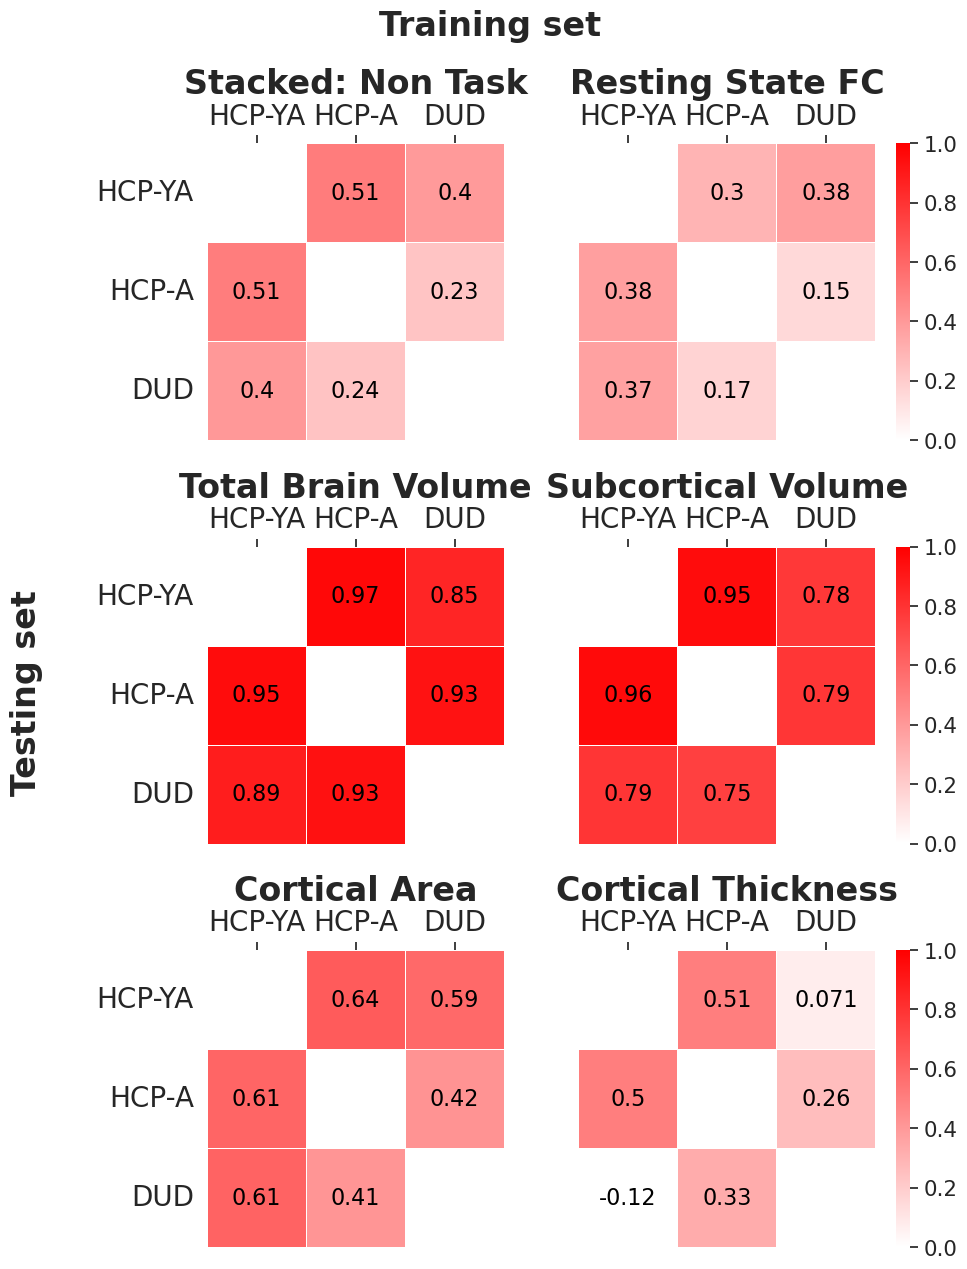

In [52]:
sns.set_style("whitegrid", {'axes.grid' : False})
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

ax_label = ['HCP-YA', 'HCP-A', 'DUD']
cmap = LinearSegmentedColormap.from_list('name', ['white', 'red'])#sns.diverging_palette(-10, 20, as_cmap=True)


fig = plt.figure(figsize=(10,13))
i=1
for mod in order.index:
    nms = order.loc[mod,'label']
    
    plt.subplot(3, 2, i)
    
    data = copy.deepcopy(dct_mod_gen_cor[mod])
    data.index = ax_label
    data.columns = ax_label
    if i%2 != 0 :
        cbar = False
    else:
        cbar = True
    ax = sns.heatmap(data,  cbar=cbar, annot=True,#mat_ci[mod],
                     cmap=cmap,#'afmhot_r', 
                     vmin=0, vmax=1, 
                     linewidth=.5, fmt = '.2', 
                     annot_kws={"fontsize":16, 'color':'black'}, square=True)
     
    sns.set(font_scale=1.4)
    ax.xaxis.tick_top()
    plt.xticks(rotation=0, fontsize=20)
    
    plt.title(nms, fontsize=24, fontweight="bold")
    
    if i%2 != 0 :
        plt.yticks(rotation=0, fontsize=20)
    else:
        plt.yticks([],rotation=0, fontsize=20)
    sns.set_style("whitegrid", {'axes.grid' : False})
    i+=1
    
fig.supxlabel('Training set', y=1, fontsize=24, fontweight="bold")
fig.supylabel('Testing set', fontsize=24, fontweight="bold")
fig.tight_layout()

#plt.savefig(path_img_out+'generalizability_cor_plot_type2_image.svg',bbox_inches='tight')
#plt.savefig(path_img_out+'generalizability_cor_plot_type2_image.png',bbox_inches='tight')
plt.show()

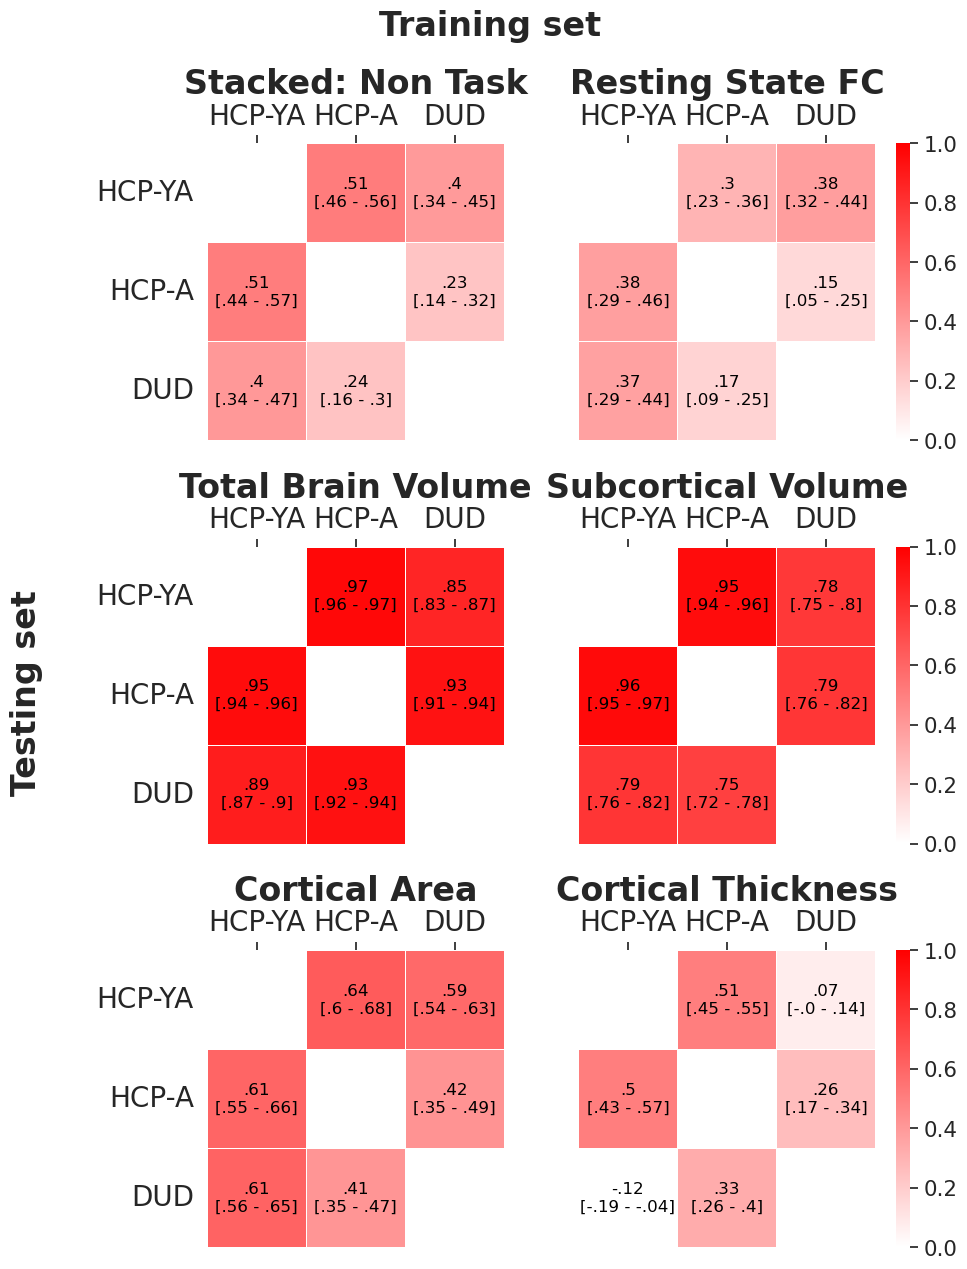

In [53]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

ax_label = ['HCP-YA', 'HCP-A', 'DUD']
cmap = LinearSegmentedColormap.from_list('name', ['white', 'red'])#sns.diverging_palette(-10, 20, as_cmap=True)


fig = plt.figure(figsize=(10,13))
i=1
for mod in order.index:
    nms = order.loc[mod,'label']
    
    plt.subplot(3, 2, i)
    
    data = copy.deepcopy(dct_mod_gen_cor[mod])
    data.index = ax_label
    data.columns = ax_label
    if i%2 != 0 :
        cbar = False
    else:
        cbar = True
    ax = sns.heatmap(data, annot=mat_ci[mod], cbar=cbar,
                     cmap=cmap,#'afmhot_r', 
                     vmin=0, vmax=1, 
                     linewidth=.5, fmt = '', 
                     annot_kws={"fontsize":12, 'color':'black'}, square=True)
     
    sns.set(font_scale=1.4)
    ax.xaxis.tick_top()
    plt.xticks(rotation=0, fontsize=20)
    
    plt.title(nms, fontsize=24, fontweight="bold")
    
    if i%2 != 0 :
        plt.yticks(rotation=0, fontsize=20)
    else:
        plt.yticks([],rotation=0, fontsize=20)
    sns.set_style("whitegrid", {'axes.grid' : False})
    
    i+=1
   
fig.supxlabel('Training set', y=1, fontsize=24, fontweight="bold")
fig.supylabel('Testing set', fontsize=24, fontweight="bold")
fig.tight_layout()

plt.savefig(path_img_out+'generalizability_cor_ci_plot_type2_image.svg',bbox_inches='tight')
plt.savefig(path_img_out+'generalizability_cor_ci_plot_type2_image.png',bbox_inches='tight')
plt.show()